### TorchIP Models 
This notebook shows examples of how to build a (neural network) energy `model` and a `trainer` which consume _energy_ and _force components (gradient)_ to fit the model. 

A neural network performs well when interpolating and NOT extrapolating.

#### TODO:
- [x] neural network + gradient of inputs
- [x] fit example LJ potential
- [ ] trainer

In [1]:
import sys
sys.path.append('../')

import math
import torch
from torch import nn
import matplotlib.pylab as plt
torch.manual_seed(2022)

# TorchIP imports
import torchip
from torchip.config import CFG # TODO: improve it
from torchip.models import NeuralNetworkModel
from torchip.utils import gradient

In [2]:
CFG.set("device", "cpu")
print("Device:", CFG["device"])

Device: cpu


### Model

In [3]:
model = NeuralNetworkModel(input_size=3, layers=((10, 't'), (10, 't'), (1, 'l')))
print(model)

NeuralNetworkModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=1, bias=True)
    (5): Identity()
  )
)


In [4]:
def potential(x, sigma=1.0, epsilon=1.0):
    tmp6 = torch.pow(sigma/torch.norm(x, dim=1), 6)
    return (4.0*epsilon*(tmp6*tmp6 - tmp6)).view(-1, 1)

def get_position(n, requires_grad=True, factor=1.0):
    return torch.rand(n, 3, requires_grad=requires_grad) * factor + 0.5

pos = get_position(500)   # energy samples
eng = potential(pos)
pos_ = get_position(5000) # force samples
eng_ = potential(pos_)
frc = gradient(eng_, pos_)

In [ ]:
plt.scatter(torch.norm(pos_, dim=1).detach().numpy(), eng_.detach().numpy(), label="gradient")
plt.scatter(torch.norm(pos, dim=1).detach().numpy(), eng.detach().numpy(), label="potential")
plt.xlabel("x"); plt.ylabel("y, dy"); plt.legend(loc='lower right'); plt.title("samples");

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.MSELoss()

def train(model, optimizer, loss_fn, epochs=5000):
    """
    Train input model using provided optimizer, loss function, and data.
    """
    for epoch in range(epochs):
        strout = f"Epoch: [{epoch+1}/{epochs}]"
        
        # Training 
        training_loss = 0.0
        model.train()
        optimizer.zero_grad()
        eng_ =  model(pos)
        frc_ = gradient(model(pos_), pos_)
        eng_loss = criterion(eng_, eng) 
        frc_loss = criterion(frc_, frc)
        loss = eng_loss + frc_loss
        loss.backward(retain_graph=True)
        optimizer.step()
        strout += f", Training Loss: energy={eng_loss.data.item():.8f}, force={frc_loss.data.item():.8f}, total={loss.data.item():.8f}"
        
#         # Validation
#         valid_loss = 0.0
#         model.eval()
#         y =  model(x_val)
#         dy = gradient(y, x_val)
#         loss = criterion(y, y_val) + criterion(dy, dy_val)
#         valid_loss += loss.data.item()
#         strout += f", Valid Loss: {valid_loss:.8f}"

        if epoch==0 or (epoch+1) % 500 == 0:
            print(strout)
        

In [11]:
train(model, optimizer, criterion)

Epoch: [1/5000], Training Loss: energy=0.00004612, force=0.00248909, total=0.00253522
Epoch: [500/5000], Training Loss: energy=0.00004533, force=0.00229260, total=0.00233793
Epoch: [1000/5000], Training Loss: energy=0.00004219, force=0.00215819, total=0.00220038
Epoch: [1500/5000], Training Loss: energy=0.00004732, force=0.00204810, total=0.00209542
Epoch: [2000/5000], Training Loss: energy=0.00004708, force=0.00199377, total=0.00204085
Epoch: [2500/5000], Training Loss: energy=0.00003441, force=0.00189589, total=0.00193030
Epoch: [3000/5000], Training Loss: energy=0.00003270, force=0.00184041, total=0.00187311
Epoch: [3500/5000], Training Loss: energy=0.00003176, force=0.00178787, total=0.00181963
Epoch: [4000/5000], Training Loss: energy=0.00003119, force=0.00173892, total=0.00177010
Epoch: [4500/5000], Training Loss: energy=0.00029147, force=0.00186766, total=0.00215913
Epoch: [5000/5000], Training Loss: energy=0.00004024, force=0.00166810, total=0.00170835


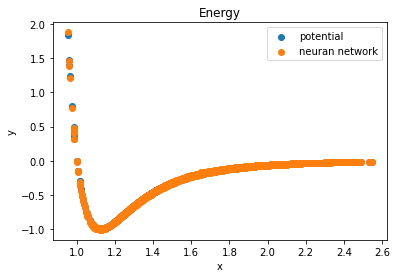

In [14]:
pos = get_position(5000, factor=1)
plt.scatter(torch.norm(pos, dim=1).detach().numpy(), potential(pos).detach().numpy(), label="potential")
plt.scatter(torch.norm(pos, dim=1).detach().numpy(), model(pos).detach().numpy(), label="neuran network")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.title("Energy");

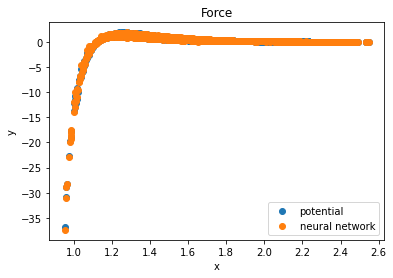

In [15]:
# pos = get_position(1000)
plt.scatter(torch.norm(pos, dim=1).detach().numpy(), gradient(potential(pos), pos)[:, 0].detach().numpy(), label="potential")
plt.scatter(torch.norm(pos, dim=1).detach().numpy(), gradient(model(pos), pos)[:, 0].detach().numpy(), label="neural network")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.title("Force");